In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imp import load_source

aps = load_source(  'aggregate_player_stats', '../exploration/aggregate_player_stats.py' )
nps = load_source(  'normalize_player_stats', '../normalization/normalize_player_stats.py' )

%matplotlib inline

plt.rcParams['figure.figsize'] = (14,10)
plt.style.use('dark_background')

In [3]:
position = 'QB'
n_weeks  = 4
end_year = 2017

my_df = aps.generate_player_features( end_year, position, n_weeks=n_weeks )

In [4]:
target_variables = [
                    'log_rush_yds_25',
#                    'rush_tds',
                    'log_pass_yds_1',
#                    'pass_tds',
                    'turnovers',
#
                    'tds'
                   ]

meta_info     = [
                 'player_id',
                 'team',
                 'week',
                 'year',
                 'team_home_frac_prev_4',
#                 'few_reg_weeks'
                ]


player_scales = [
                 'pass_complete_prev_4',
                 'pass_incomplete_prev_4',
                 'pass_air_yds_prev_4',
                 'pass_air_yds_max_prev_4',
                 'pass_yds_prev_4',
                 'pass_att_prev_4'
                ]

player_norms = [
                'pass_int_prev_4',
                'pass_tds_prev_4',
                'rush_yds_prev_4',
                'rush_tds_prev_4',
                'rush_att_prev_4'
                ]

fumb_features    = [
                    'fumb_lost_prev_4', 
                    'fumb_rec_prev_4', 
                    'fumb_forced_prev_4', 
                    'fumb_nforced_prev_4'
                   ]

team_features    = [
                    'team_tds_prev_4',
                    'team_fg_made_prev_4',
                    'team_kickoffs_prev_4',
                    'team_punts_prev_4'
                   ]


opp_features     = [
                    'opp_avg_tds_prev_4', 
                    'opp_avg_fg_made_prev_4',
                    'opp_avg_rush_yds_prev_4', 
                    'opp_avg_pass_yds_prev_4',
                    'opp_avg_def_tkl_loss_prev_4', 
                    'opp_avg_def_sack_prev_4', 
                    'opp_avg_def_pass_def_prev_4'
                   ]

In [5]:
# Make turnovers a feature
temp_df = my_df.copy()

temp_df['turnovers'] = temp_df['pass_int']+temp_df['fumb_lost']
temp_df = temp_df.drop( ['pass_int','fumb_lost'], axis=1 )

# Not calc the frac of home games
temp_df['team_home_frac_prev_4'] = temp_df['team_home_flag_prev_4'] / \
                                  (temp_df['team_home_flag_prev_4'] +
                                   temp_df['team_away_flag_prev_4'] +
                                   0.                               )
temp_df = temp_df.drop( ['team_home_flag_prev_4','team_away_flag_prev_4'], axis=1 )


#
# Combine touchdowns
temp_df['tds'] = temp_df['pass_tds'] + temp_df['rush_tds']
temp_df = temp_df.drop( ['pass_tds','rush_tds'], axis=1 )

#
# Do logs of rush and passing yds
temp_df['log_pass_yds_1' ] = np.log10( temp_df['pass_yds']+ 1. ).fillna(0)
temp_df['log_rush_yds_25'] = np.log10( temp_df['rush_yds']+25. )
temp_df = temp_df.drop( ['pass_yds','rush_yds'], axis=1 )

#
# Only take regular seasons
temp_df = temp_df.loc[ temp_df['few_reg_weeks']==0 ]
temp_df = temp_df.drop( 'few_reg_weeks', axis=1 )

/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


In [6]:
# Let's start by training
#  on all data pre-2016
# Apparently 2017 preseason data missing from the db
my_train_data = temp_df.loc[ my_df['year']< 2017 ].reset_index().drop( 'index', axis=1 )
my_test_data  = temp_df.loc[ my_df['year']>=2017 ].reset_index().drop( 'index', axis=1 )

In [7]:
# Dictionary to save normalization data in
norm_dict = {}

# Do seperately
df_list = [
            my_train_data,
            my_test_data
          ]

out_df_list = []

# By looping over these,
#  will set data using train data,
#  then apply stuff to test data
# Adds then uses values from the dict
for frame in df_list:
    
    
    # Grab some normalized fumble features
    fumb_junk = nps.fumb_normalization( 
                                        frame, 
                                        fumb_features,
                                        norm_dict
                                      )
    
    # Some normalized team features
    team_junk = nps.team_normalization( 
                                        frame,
                                        team_features,
                                        norm_dict,
                                        'team_fg_miss_prev_4'
                                      )
    
    # Some opposing team features
    opp_junk = nps.opp_normalization( 
                                      frame,
                                      opp_features,
                                      norm_dict
                                    )
    
    # The QB features
    qb_junk = nps.qb_normalization(
                                    frame,
                                    player_norms,
                                    player_scales,
                                    norm_dict
                                  )
    
    # What we will output
    new_frame = frame[meta_info+target_variables]

    # Combine all the stuff into 1 frame
    out_df_list.append(
                        pd.concat( [
                                    new_frame,
                                    qb_junk,
                                    fumb_junk,
                                    team_junk,
                                    opp_junk
                                   ], axis=1).copy()
                      )
    
    
train_norm_data = out_df_list[0].copy()
test_norm_data  = out_df_list[1].copy()
out_df_list     = 0

In [8]:
# 21 features
features = test_norm_data.columns.values[9: ].tolist()+['team_home_frac_prev_4']
targets  = ['log_pass_yds_1','log_rush_yds_25','turnovers','tds']

print test_norm_data.columns
print features
print targets

Index([                     u'player_id',                           u'team',
                                 u'week',                           u'year',
                u'team_home_frac_prev_4',                u'log_rush_yds_25',
                       u'log_pass_yds_1',                      u'turnovers',
                                  u'tds',    u'pass_complete_prev_4_scaled',
        u'pass_incomplete_prev_4_scaled',     u'pass_air_yds_prev_4_scaled',
       u'pass_air_yds_max_prev_4_scaled',         u'pass_yds_prev_4_scaled',
               u'pass_att_prev_4_scaled',           u'pass_int_prev_4_norm',
                 u'pass_tds_prev_4_norm',           u'rush_yds_prev_4_norm',
                 u'rush_tds_prev_4_norm',           u'rush_att_prev_4_norm',
                      u'fumb_pca_0_norm',           u'fumb_pca_1_bc_scaled',
                    u'team_pca_0_scaled',              u'team_pca_1_scaled',
           u'team_fg_miss_prev_4_scaled',               u'opp_pca_0_scaled',

In [9]:
train_x, train_y = train_norm_data[features].values, train_norm_data[targets].values
test_x ,  test_y =  test_norm_data[features].values,  test_norm_data[targets].values

Let's pick some regressors. We will start with a linear regressor, lasso regressor, kneighbors, random forest, and neural network.

We'll do a first round test, select the best, and fine tune from there

In [12]:
from sklearn.linear_model   import LinearRegression
from sklearn.linear_model   import Lasso
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.ensemble       import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput    import MultiOutputRegressor

In [27]:
def f_rmse(pred, true, cols=['log_pass_yds_1','log_rush_yds_25','turnovers','tds'] ):
    print 'RMSE / Mean'
    for i in range(0,pred.shape[1]):
        print '%15s %8.6f' % ( cols[i], np.sqrt(((pred[:,i] - true[:,i]) ** 2).mean())/true[:,i].mean() )

def rmse(pred, true, cols=['log_pass_yds_1','log_rush_yds_25','turnovers','tds'] ):
    print 'RMSE'
    for i in range(0,pred.shape[1]):
        print '%15s %8.6f' % ( cols[i], np.sqrt(((pred[:,i] - true[:,i]) ** 2).mean()) )

def r2( pred, true, cols=['log_pass_yds_1','log_rush_yds_25','turnovers','tds'] ):
    print 'R^2'
    for i in range(0,pred.shape[1]):
        y = true[:,i]
        # fit values, and mean
        yhat  = pred[:,i]                # or [p(z) for z in x]
        ybar  = np.sum(y)/len(y)         # or sum(y)/len(y)
        ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
        sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
        print '%15s %8.6f' % ( cols[i], ssreg / sstot )
        
def reg_test( reg, train_x, train_y, test_x, test_y ):
    reg.fit( train_x, train_y )
    print 'Train Data:'
    r2    ( reg.predict( train_x ), train_y )
    rmse  ( reg.predict( train_x ), train_y )
    f_rmse( reg.predict( train_x ), train_y )
    print 'Test Data:'
    r2    ( reg.predict( test_x ), test_y )
    rmse  ( reg.predict( test_x ), test_y )
    f_rmse( reg.predict( test_x ), test_y )

Train Data:
R^2
 log_pass_yds_1 0.320871
log_rush_yds_25 0.316225
      turnovers 0.023537
            tds 0.088738
RMSE
 log_pass_yds_1 0.285324
log_rush_yds_25 0.132551
      turnovers 1.029209
            tds 1.167609
RMSE / Mean
 log_pass_yds_1 0.123316
log_rush_yds_25 0.086881
      turnovers 1.020894
            tds 0.718173
Test Data:
R^2
 log_pass_yds_1 0.273053
log_rush_yds_25 0.303443
      turnovers 0.028230
            tds 0.097402
RMSE
 log_pass_yds_1 0.321835
log_rush_yds_25 0.131224
      turnovers 1.018696
            tds 1.105048
RMSE / Mean
 log_pass_yds_1 0.140743
log_rush_yds_25 0.085250
      turnovers 1.110074
            tds 0.714903


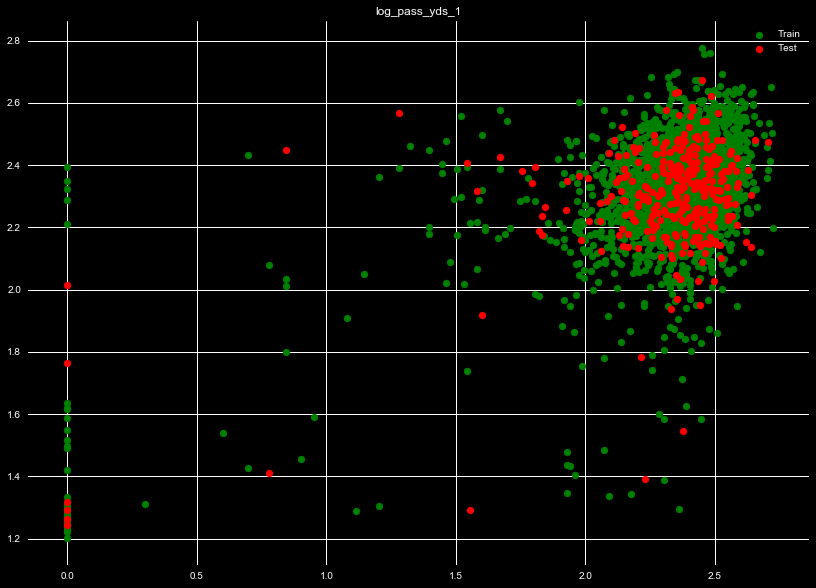

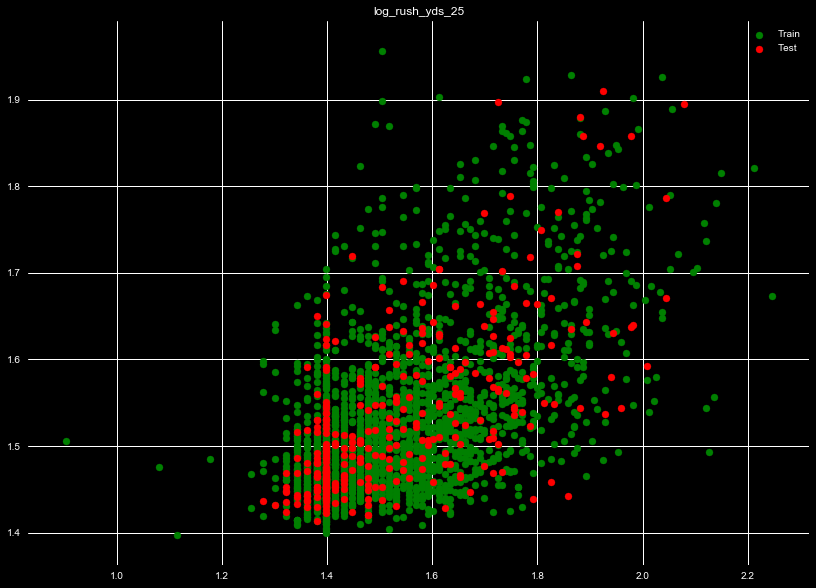

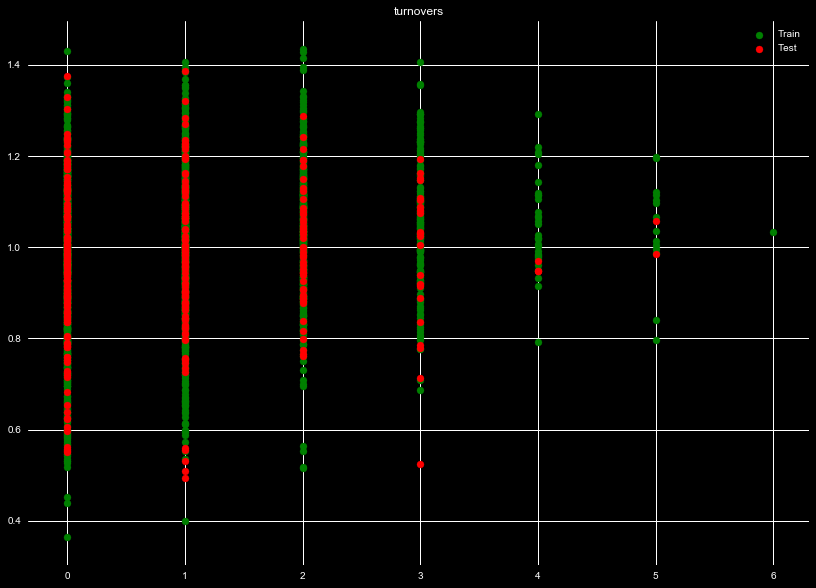

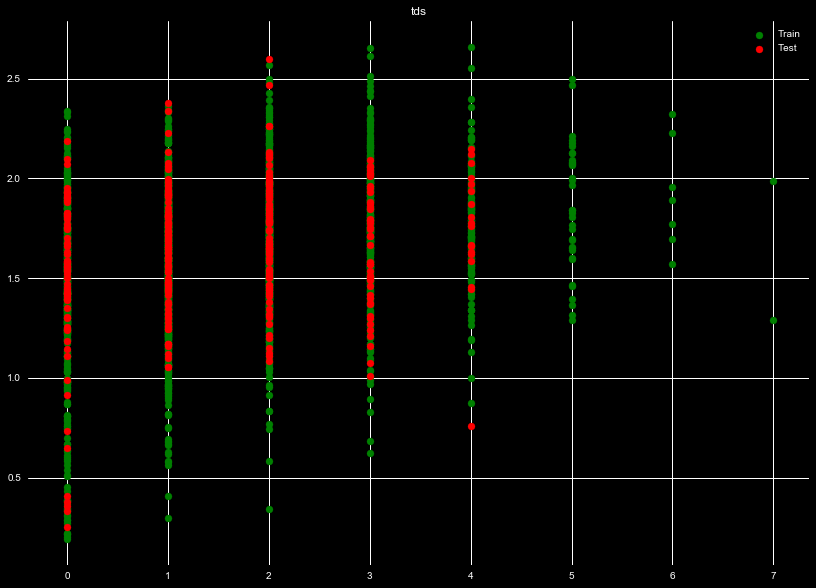

In [29]:
m_lin_reg = MultiOutputRegressor( LinearRegression() )

reg_test( m_lin_reg, train_x, train_y, test_x, test_y )

pred_test  = m_lin_reg.predict(  test_x )
pred_train = m_lin_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train' )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test'  )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.000000
log_rush_yds_25 0.000000
      turnovers 0.000000
            tds 0.000000
RMSE
 log_pass_yds_1 0.346229
log_rush_yds_25 0.160297
      turnovers 1.041539
            tds 1.223139
RMSE / Mean
 log_pass_yds_1 0.149638
log_rush_yds_25 0.105067
      turnovers 1.033125
            tds 0.752329
Test Data:
R^2
 log_pass_yds_1 0.004976
log_rush_yds_25 0.006421
      turnovers 0.007923
            tds 0.005113
RMSE
 log_pass_yds_1 0.385049
log_rush_yds_25 0.170572
      turnovers 1.020314
            tds 1.122683
RMSE / Mean
 log_pass_yds_1 0.168388
log_rush_yds_25 0.110812
      turnovers 1.111838
            tds 0.726312


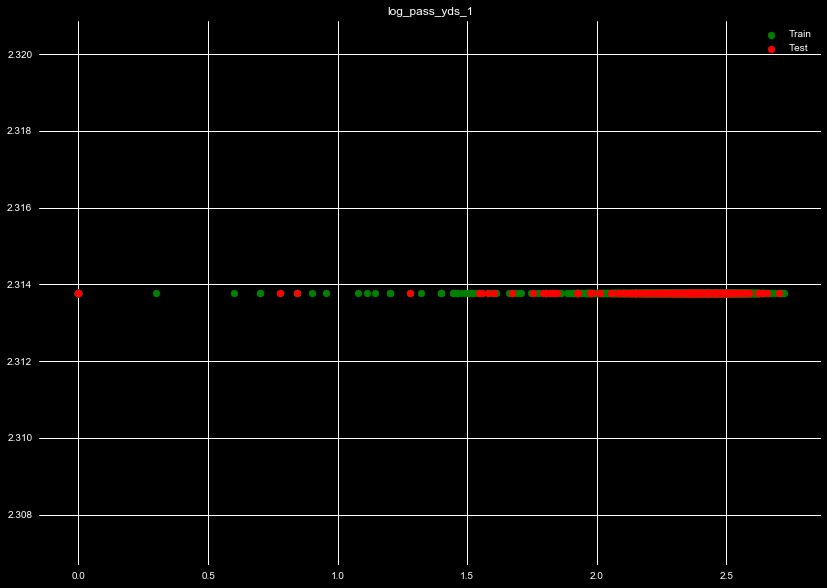

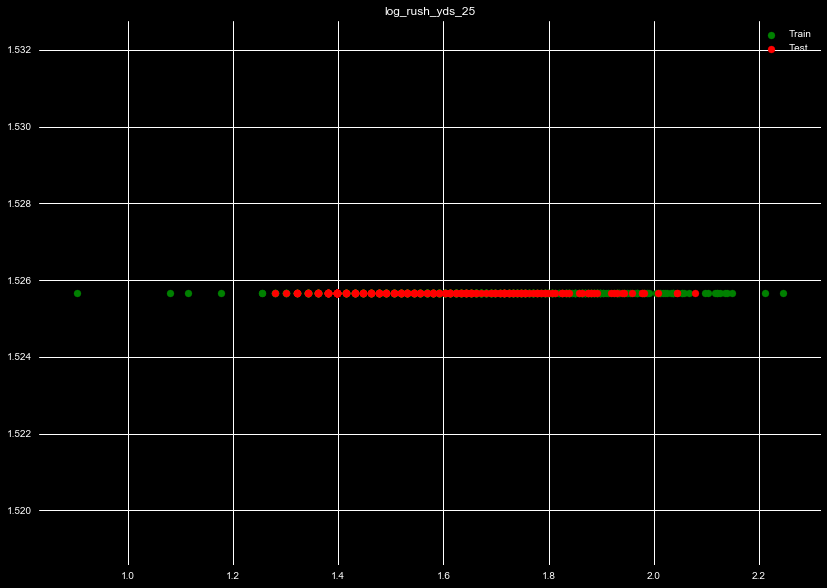

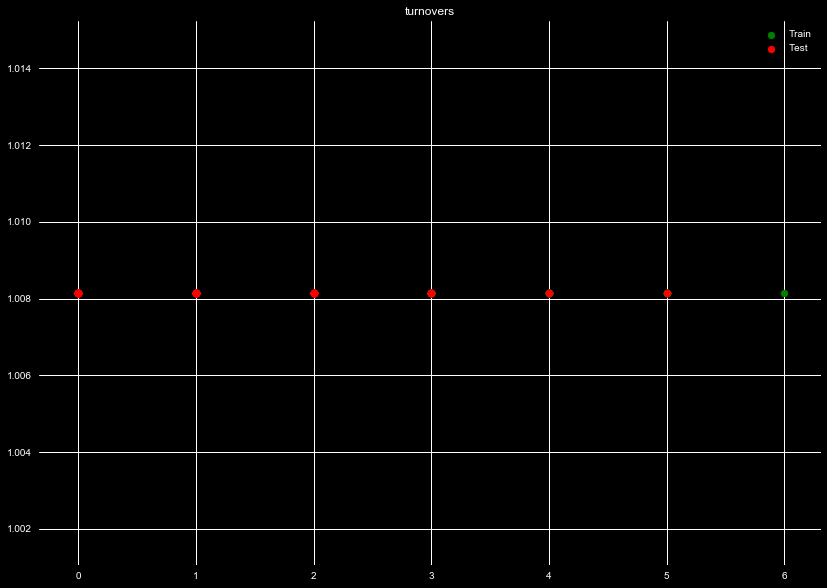

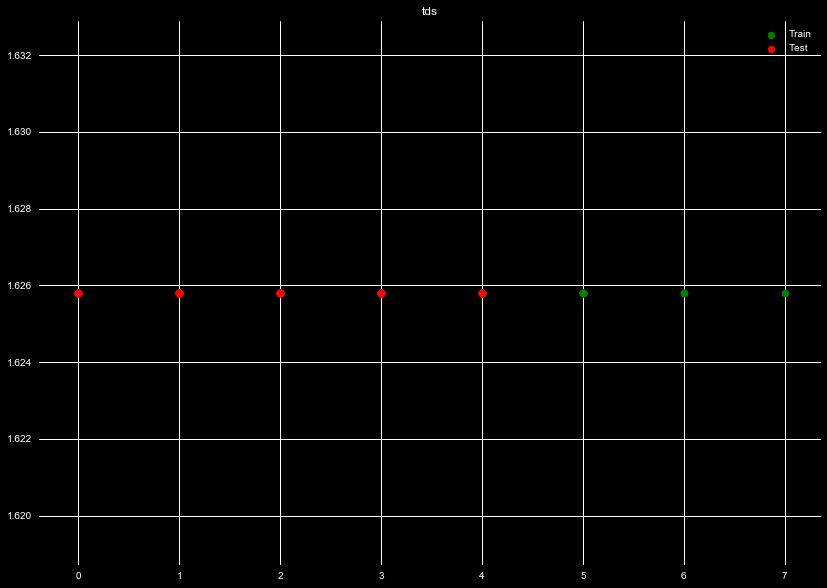

In [30]:
m_las_reg = MultiOutputRegressor( Lasso(alpha=0.5) )

reg_test( m_las_reg, train_x, train_y, test_x, test_y )

pred_test  = m_las_reg.predict(  test_x )
pred_train = m_las_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train' )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test'  )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.571963
log_rush_yds_25 0.345768
      turnovers 0.215235
            tds 0.255131
RMSE
 log_pass_yds_1 0.230821
log_rush_yds_25 0.121506
      turnovers 0.915645
            tds 1.036480
RMSE / Mean
 log_pass_yds_1 0.099760
log_rush_yds_25 0.079642
      turnovers 0.908248
            tds 0.637518
Test Data:
R^2
 log_pass_yds_1 0.674322
log_rush_yds_25 0.274223
      turnovers 0.273957
            tds 0.304298
RMSE
 log_pass_yds_1 0.313421
log_rush_yds_25 0.168526
      turnovers 1.117216
            tds 1.240722
RMSE / Mean
 log_pass_yds_1 0.137064
log_rush_yds_25 0.109483
      turnovers 1.217431
            tds 0.802676


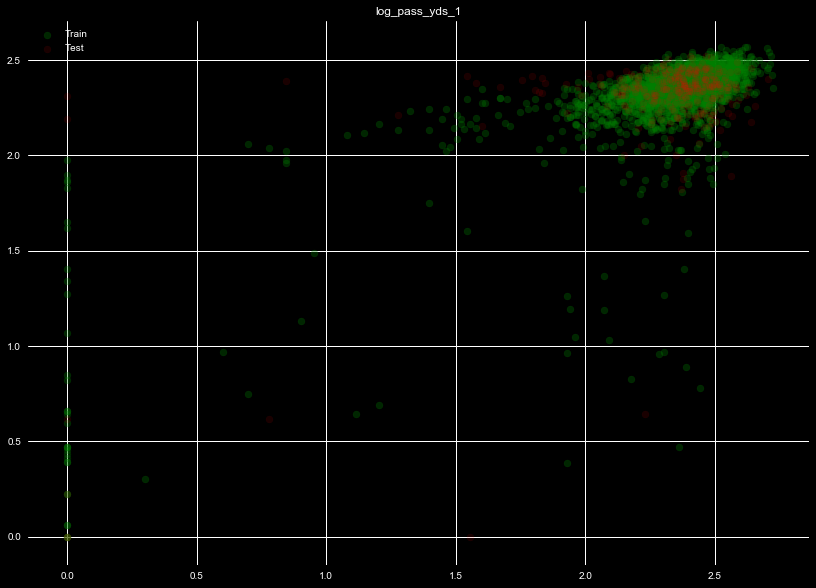

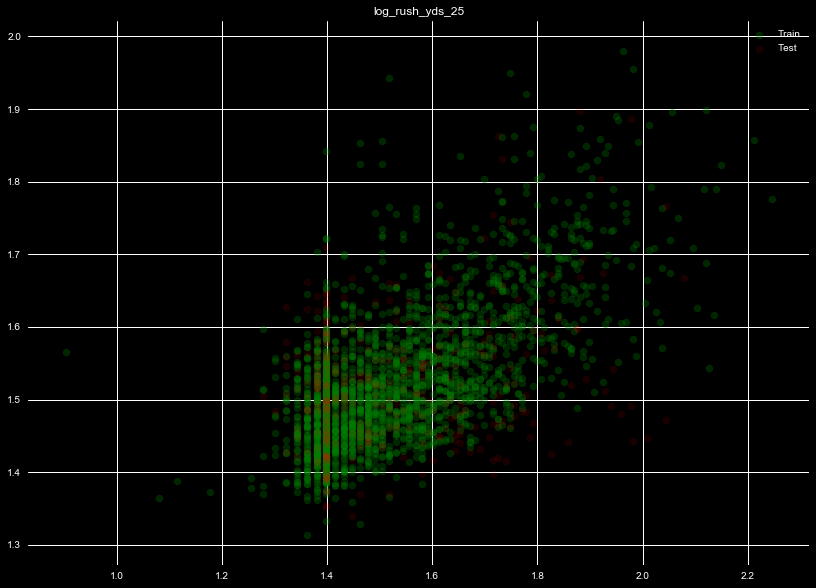

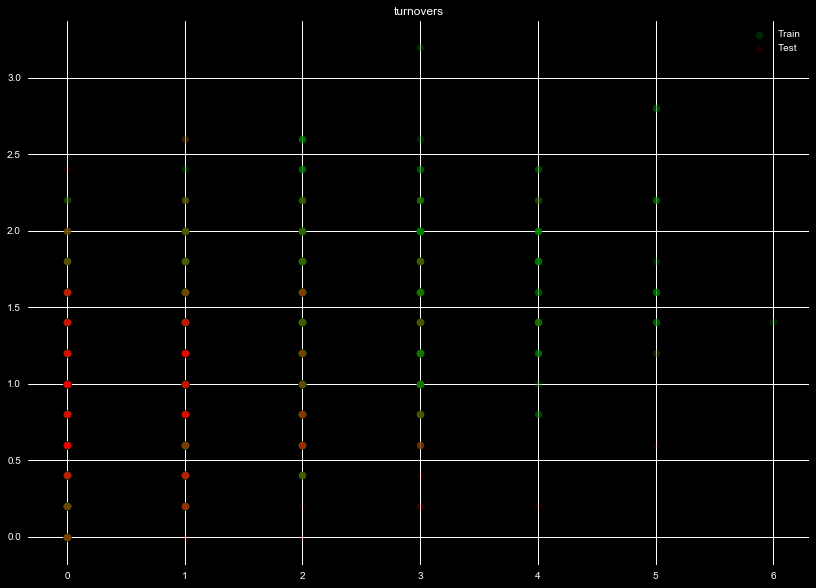

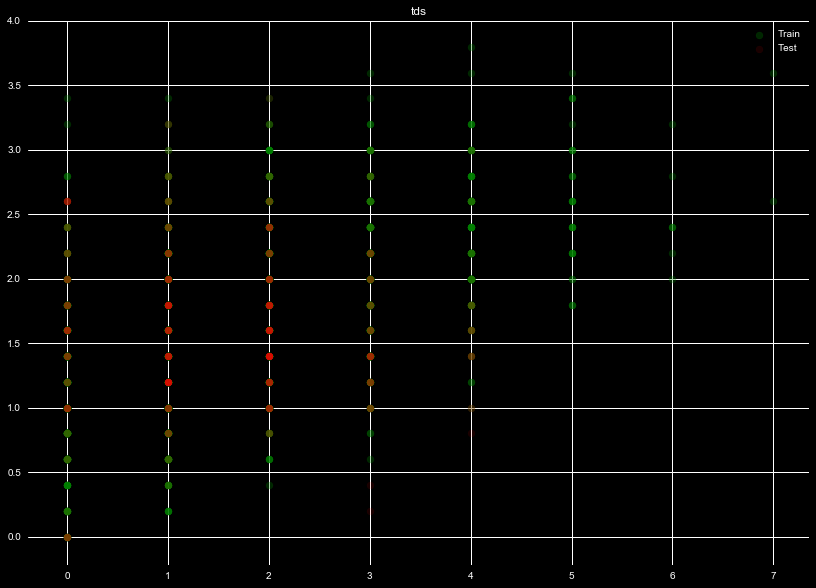

In [31]:
m_knn_reg = MultiOutputRegressor( KNeighborsRegressor(n_neighbors=5) )

reg_test( m_knn_reg, train_x, train_y, test_x, test_y )

pred_test  = m_knn_reg.predict(  test_x )
pred_train = m_knn_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.753205
log_rush_yds_25 0.633575
      turnovers 0.463989
            tds 0.491373
RMSE
 log_pass_yds_1 0.114631
log_rush_yds_25 0.059584
      turnovers 0.470620
            tds 0.536874
RMSE / Mean
 log_pass_yds_1 0.049543
log_rush_yds_25 0.039054
      turnovers 0.466818
            tds 0.330221
Test Data:
R^2
 log_pass_yds_1 0.626687
log_rush_yds_25 0.380474
      turnovers 0.166144
            tds 0.245709
RMSE
 log_pass_yds_1 0.294034
log_rush_yds_25 0.147084
      turnovers 1.035557
            tds 1.171928
RMSE / Mean
 log_pass_yds_1 0.128586
log_rush_yds_25 0.095553
      turnovers 1.128447
            tds 0.758170


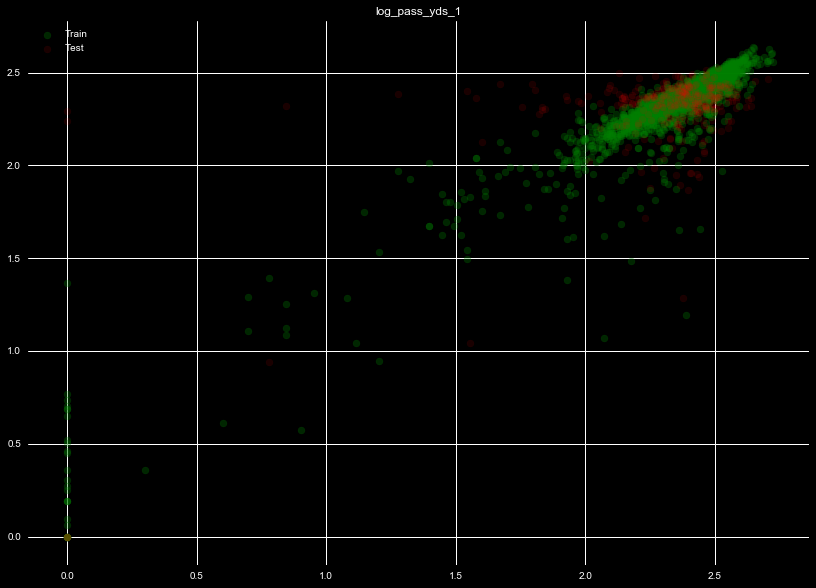

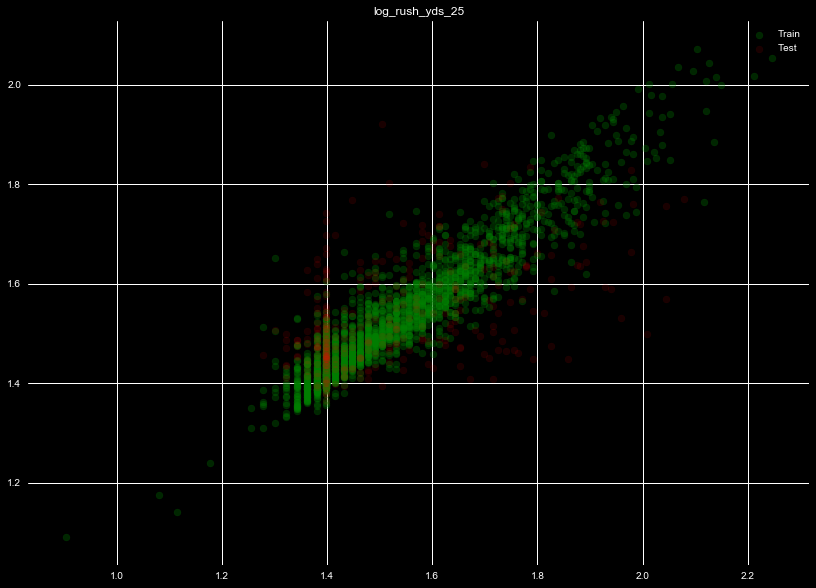

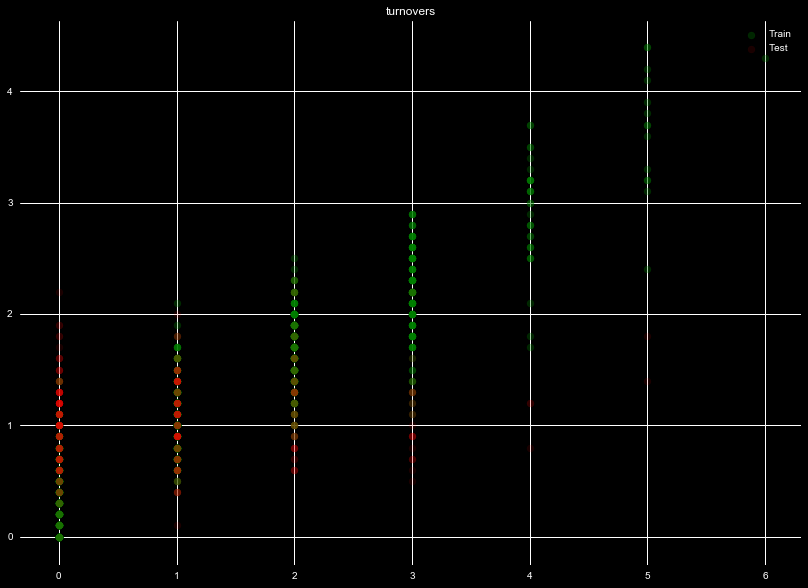

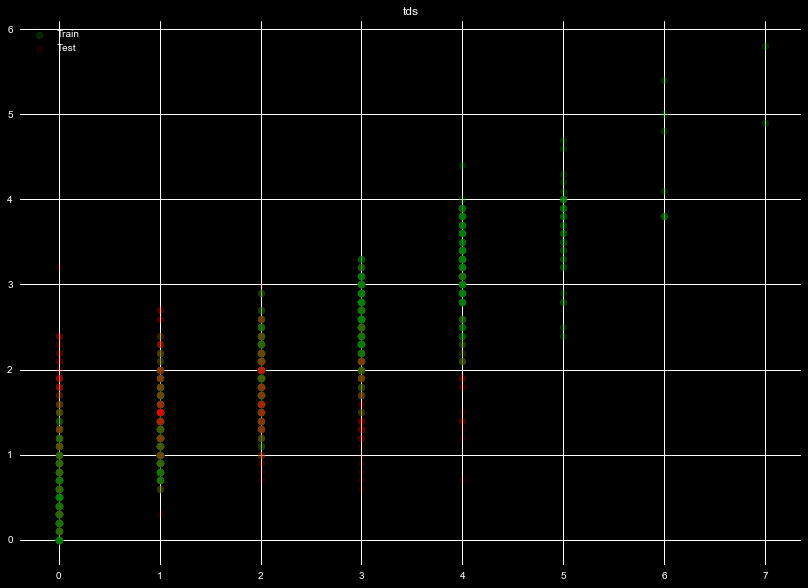

In [32]:
m_rfr_reg = MultiOutputRegressor( RandomForestRegressor() )

reg_test( m_rfr_reg, train_x, train_y, test_x, test_y )

pred_test  = m_rfr_reg.predict(  test_x )
pred_train = m_rfr_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.651239
log_rush_yds_25 0.545788
      turnovers 0.100976
            tds 0.181267
RMSE
 log_pass_yds_1 0.279789
log_rush_yds_25 0.134381
      turnovers 0.932865
            tds 1.032402
RMSE / Mean
 log_pass_yds_1 0.120923
log_rush_yds_25 0.088080
      turnovers 0.925329
            tds 0.635010
Test Data:
R^2
 log_pass_yds_1 0.856507
log_rush_yds_25 0.666457
      turnovers 0.156505
            tds 0.251285
RMSE
 log_pass_yds_1 0.381651
log_rush_yds_25 0.186874
      turnovers 1.033270
            tds 1.154833
RMSE / Mean
 log_pass_yds_1 0.166902
log_rush_yds_25 0.121403
      turnovers 1.125955
            tds 0.747111


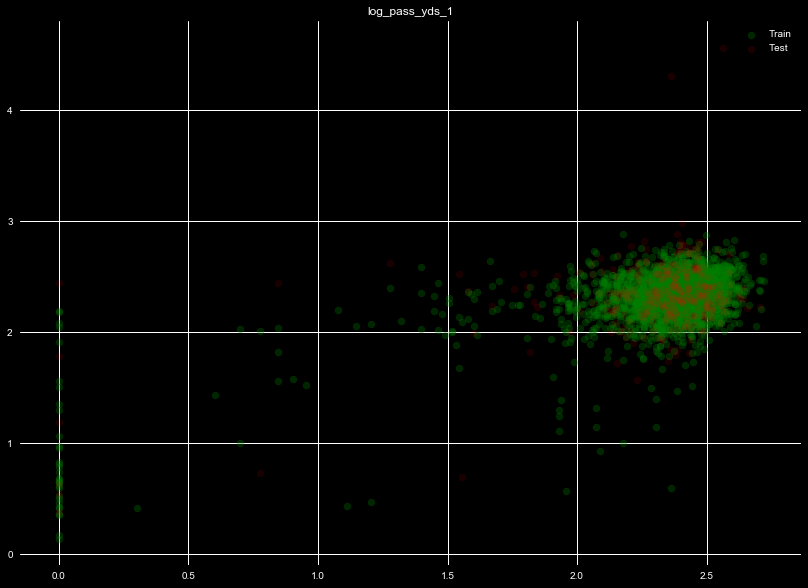

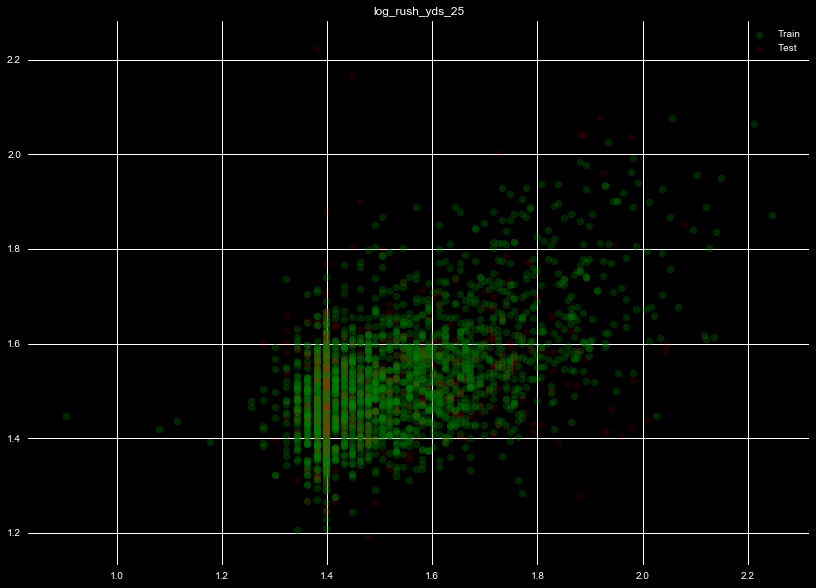

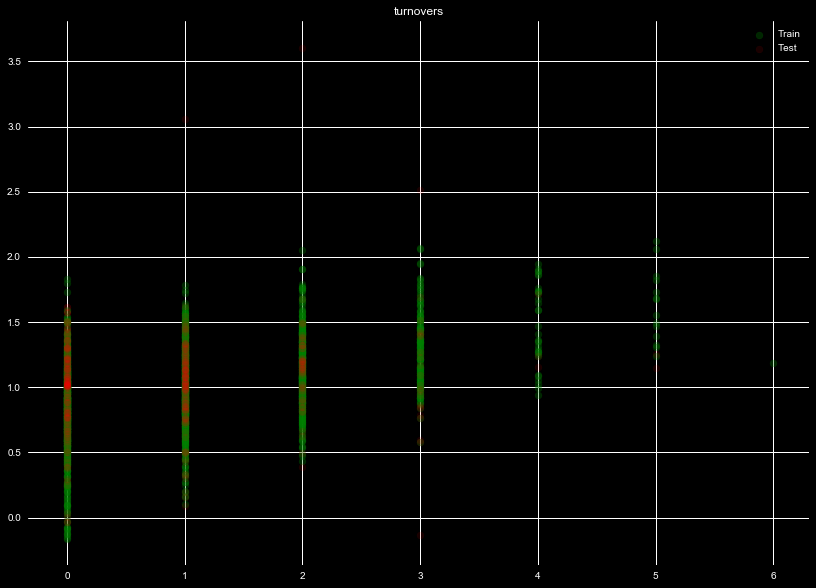

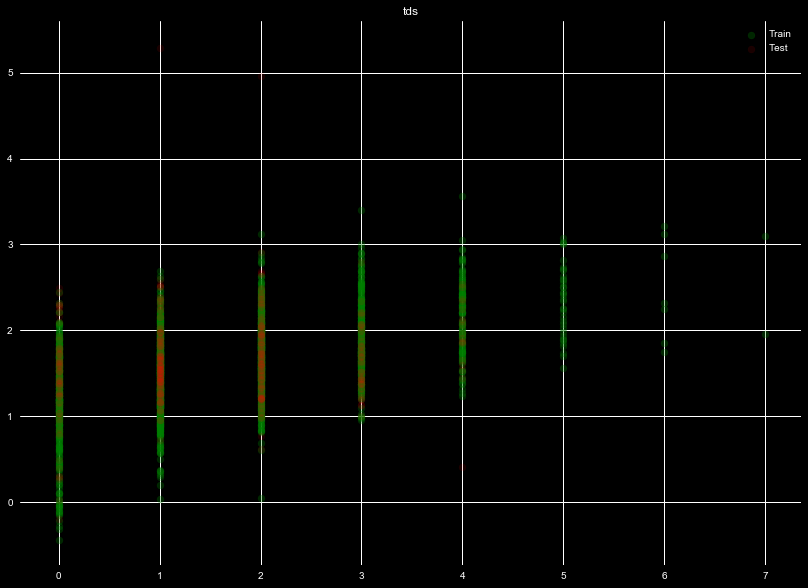

In [33]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor() )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

pred_test  = m_mlp_reg.predict(  test_x )
pred_train = m_mlp_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.592793
log_rush_yds_25 0.371811
      turnovers 0.838661
            tds 0.714380
RMSE
 log_pass_yds_1 0.192611
log_rush_yds_25 0.124039
      turnovers 0.463424
            tds 0.583472
RMSE / Mean
 log_pass_yds_1 0.083246
log_rush_yds_25 0.081301
      turnovers 0.459681
            tds 0.358882
Test Data:
R^2
 log_pass_yds_1 0.635608
log_rush_yds_25 0.321041
      turnovers 1.089842
            tds 2.934058
RMSE
 log_pass_yds_1 0.313725
log_rush_yds_25 0.152042
      turnovers 1.432389
            tds 2.222311
RMSE / Mean
 log_pass_yds_1 0.137197
log_rush_yds_25 0.098774
      turnovers 1.560876
            tds 1.437708


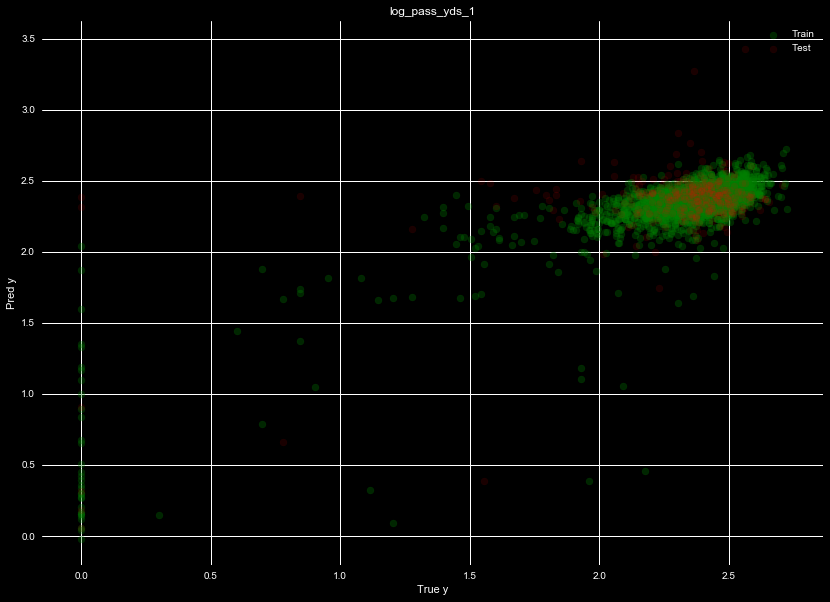

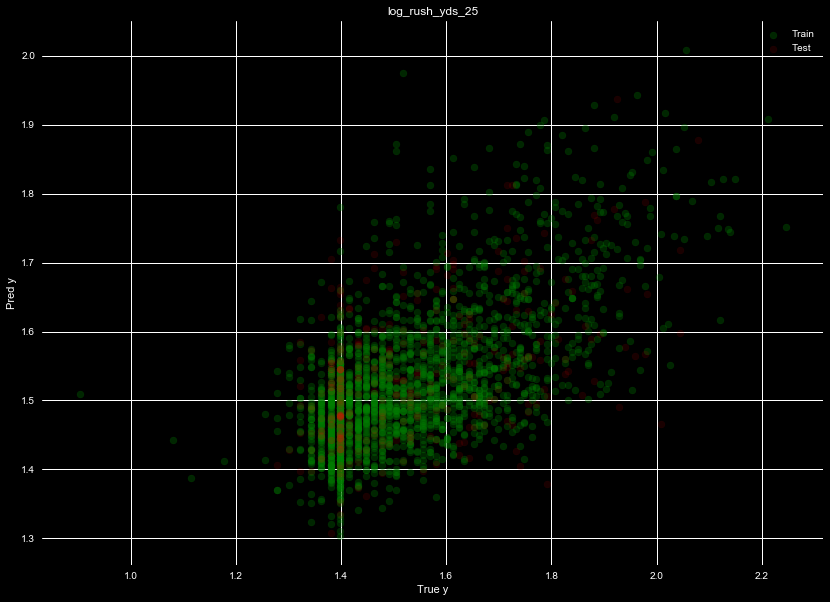

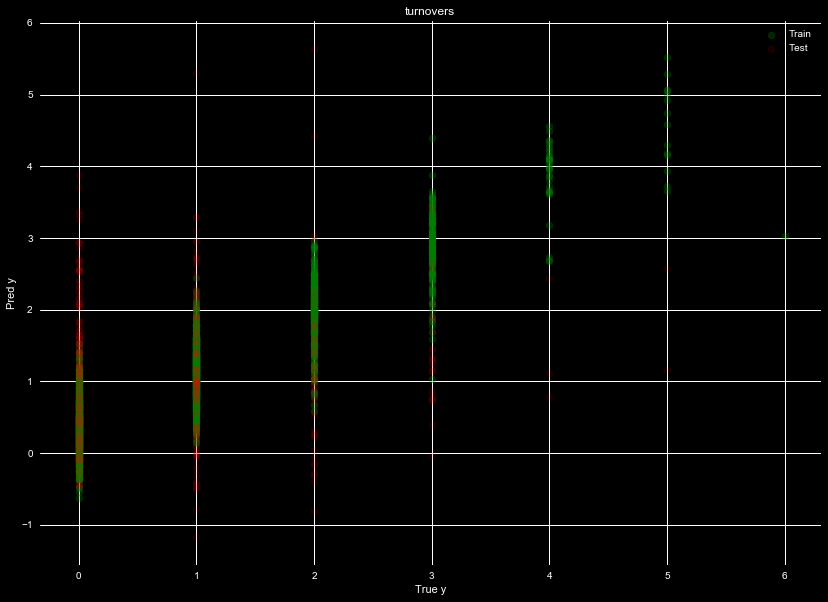

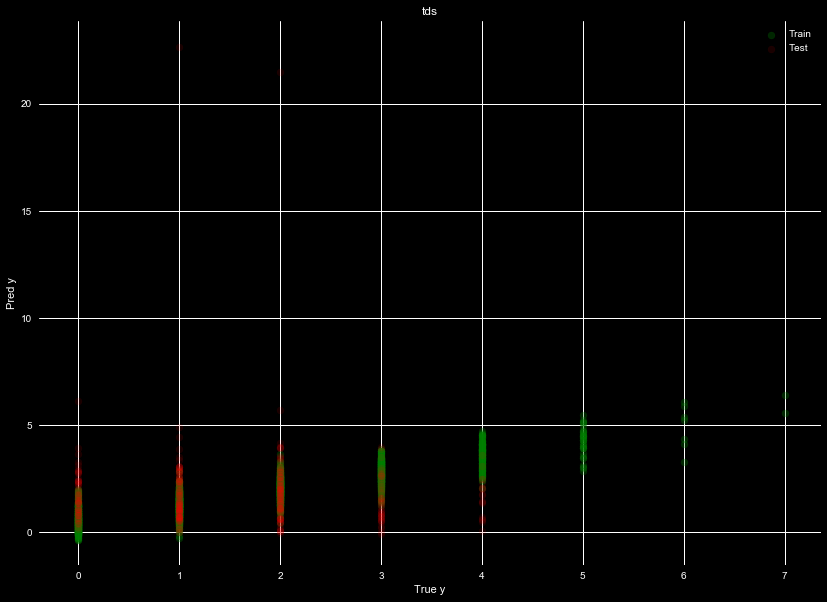

In [34]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor( hidden_layer_sizes=(50,50,50,50,50,)) )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

pred_test  = m_mlp_reg.predict(  test_x )
pred_train = m_mlp_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.xlabel( 'True y' )
    plt.ylabel( 'Pred y' )
    plt.legend()
    plt.show()

Linear regressor does ok

Lasso fails completely

Knn MIGHT be able to predict whether there are multiple turnovers, if turned into classification

RFR DEFINITELY a contender

MLP DEFINITELY a contender

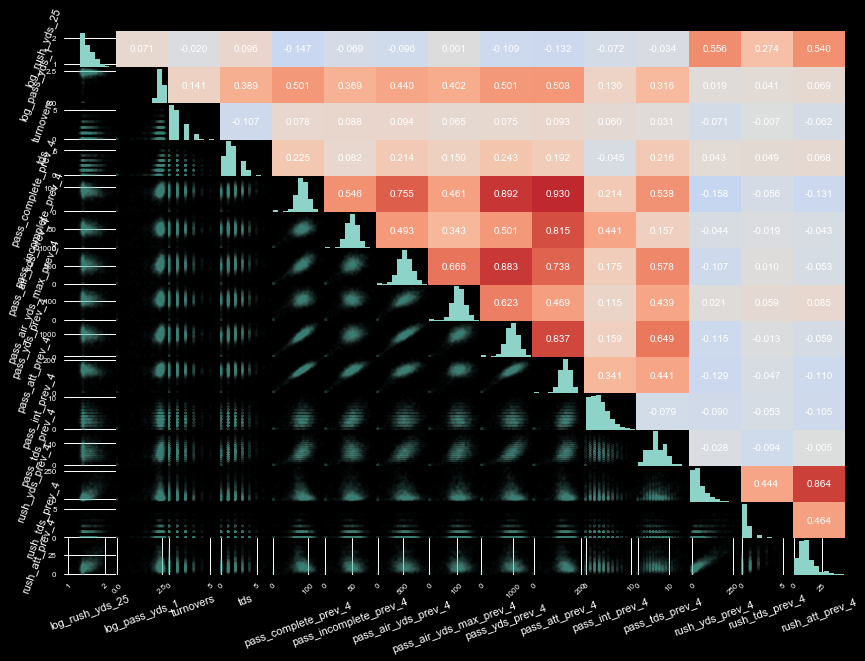

In [54]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( temp_df[target_variables+player_scales+player_norms], alpha=0.01)

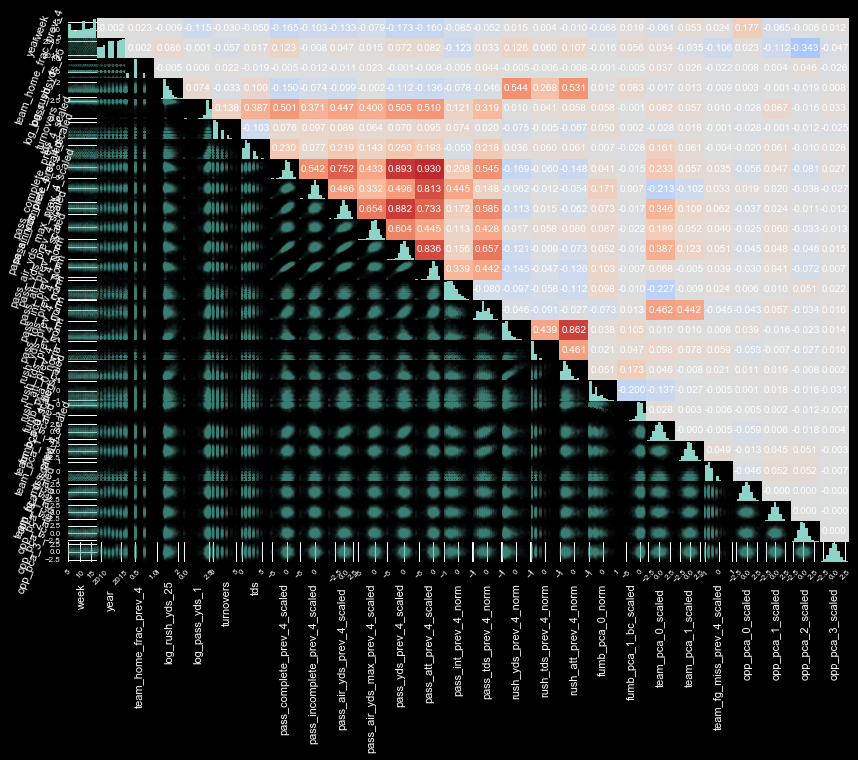

In [55]:
dv.corr_plot( train_norm_data, x_label_rotation=90, alpha=0.01)